# Goal

This code estimates the time it takes to make large numbers of pyPI runs. I randomly draw N samples from the sample dataset and then calculate their associated potential intensities with the **pi.py** module and using "apply_ufunc" in xarray. These calculations were performed on laptop with a 3.1 GHz Intel Core processor.

The size of the sample data is important because pyPI calculations are profile dependant. There are 31 vertical levels in our sample dataset, and about 126,000 points. Running the whole dataset takes about 15 seconds.

# Setup

In [2]:
# import what we need
import sys
sys.path.append(sys.path[0]+'/..')
import numpy as np
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
import time
import random
# load PI calculation module
from pyPI import pi

In [3]:
# change default figure font settings
font = {'family' : 'sans-serif',
        'weight' : 1,
        'size'   : 16}

matplotlib.rc('font', **font)

# Load Data

In [4]:
# data location
dat_loc='../data/sample_data.nc'
# load= netcdf file
ds = xr.open_dataset(dat_loc)

## Create Sample Datasets

Sample from the test data randomly to create data sets with a scaling number of points. From these we will test 10 times to capture the variability in the runtime.

In [5]:
# set the random seed
np.random.seed(2)

In [6]:
ngrid=ds.lat.size*ds.lon.size*ds.month.size
nlev=ds.p.size
print(ngrid,' ',nlev)

126144   31


In [7]:
# define the number of samples in each dataset
#nsamps=np.asarray([1e0,1e1,1e2,1e3,1e4,1e5,ngrid],dtype='int64')
nsamps=np.arange(0,100)+1
nsamps=nsamps[::5]
ncube=nsamps**3
ncube

array([     1,    216,   1331,   4096,   9261,  17576,  29791,  46656,
        68921,  97336, 132651, 175616, 226981, 287496, 357911, 438976,
       531441, 636056, 753571, 884736])

## Time the Runs

In [8]:
# create the time elapsed array
nruns=10
time_elapsed=np.zeros((nruns,len(nsamps)),dtype='float64')
from xarray import apply_ufunc

time0=time.time()

for j in range(len(nsamps)):
    rlat,rlon,rmon=np.random.randint(0,ds.lat.size,nsamps[j]),np.random.randint(0,ds.lon.size,nsamps[j]),np.random.randint(0,ds.month.size,nsamps[j])
    ds0=ds.isel(lat=rlat,lon=rlon,month=rmon)
    
    for i in range(nruns):
        start_time = time.time()
        result = apply_ufunc(
            pi,
            ds0['sst'], ds0['msl'], ds0['p'], ds0['t'], ds0['q'],
            kwargs=dict(CKCD=0.9, ascent_flag=0, diss_flag=1, miss_handle=1),
            input_core_dims=[
                [], [], ['p', ], ['p', ], ['p', ],
            ],
            output_core_dims=[
                [], [], [], [], []
            ],
            vectorize=True
        )
        time_elapsed[i,j]=time.time()-start_time
    del rlat, rlon, rmon, ds0
    print(str(j)+'   Time Elapsed='+str(time.time()-time0))

0   Time Elapsed=4.01777195930481
1   Time Elapsed=7.453341960906982
2   Time Elapsed=13.447799921035767
3   Time Elapsed=26.296851873397827
4   Time Elapsed=54.94312500953674
5   Time Elapsed=111.17711591720581
6   Time Elapsed=178.04299807548523
7   Time Elapsed=283.1557900905609
8   Time Elapsed=423.86614298820496
9   Time Elapsed=617.5163240432739
10   Time Elapsed=832.5707020759583
11   Time Elapsed=1133.0132489204407
12   Time Elapsed=1551.0166070461273
13   Time Elapsed=2021.6843750476837
14   Time Elapsed=2632.807121992111
15   Time Elapsed=3182.675828933716
16   Time Elapsed=4044.3963158130646
17   Time Elapsed=4890.424643039703
18   Time Elapsed=5760.4049479961395
19   Time Elapsed=7127.273983001709


In [9]:
# fit a curve
z = np.polyfit(ncube,np.mean(time_elapsed,axis=0), 1)
p = np.poly1d(z)
x = np.linspace(0, 1e6, 1000)

In [10]:
print('R-squared is '+str(np.ma.corrcoef(ncube,np.mean(time_elapsed,axis=0))[0,1]**2))

R-squared is 0.9667619135142331


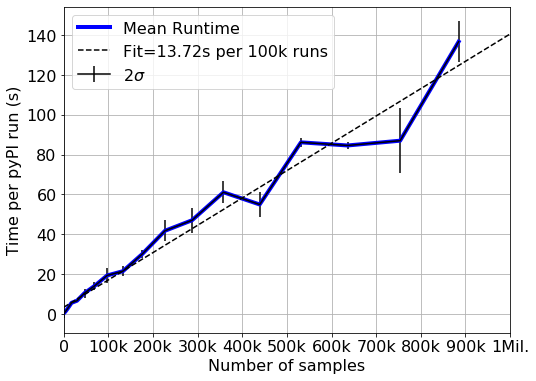

In [11]:
plt.figure(figsize=(8,6))
plt.errorbar(ncube,np.mean(time_elapsed,axis=0), yerr=2*np.std(time_elapsed,axis=0),color='k',label='2$\sigma$')
plt.plot(ncube,np.mean(time_elapsed,axis=0),'b',lw=4,label='Mean Runtime')
plt.plot(x,p(x),'--k',label='Fit='+str(round(z[0]*100000,2))+'s per 100k runs')
plt.ylabel('Time per pyPI run (s)')
plt.xlabel('Number of samples')
plt.grid()
plt.xticks(np.arange(0,1e6+1,1e5),labels=['0','100k','200k','300k','400k','500k','600k','700k','800k','900k','1Mil.'])
plt.xlim([0,1e6])
plt.legend()
plt.show()